# Goal:

* Modeling a theoretical diffusive boundary layer (DBL). 
  * A DBL may be contributing to 'smearing' observed in 16S rRNA MiSeq data from real experiments.

# Init

In [38]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [39]:
%%R
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)
library(rootSolve)

# Setting parameters

In [57]:
%%R
# tube characteristics (cm)
tube_diam = 1.3   
tube_height = 4.8
tube_round_bottom_height = 0.65
tube_capacity__ml = 4.7
tube_composition = 'polypropylene'

# rotor (cm)
rotor_id = 'TLA-110'
r_min = 2.6
r_ave = 3.72
r_max = 4.85
frac_tube_angle = 90 

# cfg run
## rpm of run
rpm = 55000
## angular velocity (w^2)
angular_velocity = 17545933.74
## average particle density
ave_gradient_density = 1.70
## beta^o  
BetaO = 1.14e9  # CsCl at density of 1.70
## position of particle at equilibrium 
particle_at_eq = 3.78 
## max 13C shift
max_13C_shift_in_BD = 0.036
## min BD (that we care about)
min_GC = 13.5
min_BD = min_GC/100.0 * 0.098 + 1.66
## max BD (that we care about)
max_GC = 80
max_BD = max_GC / 100.0 * 0.098 + 1.66    # 80.0% G+C
max_BD = max_BD + max_13C_shift_in_BD

# diffusive boundary layer (DBL)
DBL_size_range__micron = c(10,100)


# misc
fraction_vol__cm3 = 0.1

In [41]:
%%R
# rotor angle
## sin(x) = opp / hypo
## x = sin**-1(opp/hypo)

rad2deg = function(rad) {
    return((180 * rad) / pi)
}
deg2rad = function(deg){
    return(deg * pi / 180)
}


x = r_max - r_min
hyp = tube_height
rotor_tube_angle = rad2deg(asin(x / hyp))
cat("Tube angle from axis of rotation:", rotor_tube_angle, "\n")

Tube angle from axis of rotation: 27.95319 


In [42]:
%%R
# rotor angle
## sin(x) = opp / hypo
## x = sin**-1(opp/hypo)

rad2deg = function(rad) {
    return((180 * rad) / pi)
}
deg2rad = function(deg){
    return(deg * pi / 180)
}


x = r_max - r_min
hyp = tube_height
rotor_tube_angle = rad2deg(asin(x / hyp))
cat("Tube angle from axis of rotation:", rotor_tube_angle, "\n")

Tube angle from axis of rotation: 27.95319 


In [43]:
%%R
# isoconcentration point
## Formula 6.7 in Birnine and Rickwood 1978
#r_top = r_min__mm / 10
#r_bottom = r_max__mm / 10
I = sqrt((r_min**2 + r_min * r_max + r_max**2)/3)

cat('Isoconcentration point:', I, '(cm)\n')

Isoconcentration point: 3.781204 (cm)


# Determining DBL from fragment G+C content 

* fragment GC -->
* BD (diffusive boundary layer) --> 
* angled tube position of DBL -->
* vertical tube position range of DBL (min, mid, max)

# Functions for calculating DBL

## GC to BD

In [12]:
%%R
GC2BD = function(GC){ 
    # GC = percent G+C
    GC / 100.0 * 0.098 + 1.66 
}

# test
GC = seq(30, 80, 10)
sapply(GC, GC2BD)

[1] 1.6894 1.6992 1.7090 1.7188 1.7286 1.7384


## BD to distance from the axis of rotation

In [29]:
%%R
BD2distFromAxis = function(BD, D, BetaO, w2, I){
    # converting BD to distance from axis of rotation
    # BD  = density at a given radius
    # w^2 = angular velocity
    # \beta^o = beta coef
    # I = isocencentration point (cm)
    # D = average density of gradient
    sqrt(((BD-D)*2*BetaO/w2) + I^2)
}

# test
min_BD_r = BD2distFromAxis(min_BD, ave_gradient_density, BetaO, angular_velocity, I)
max_BD_r = BD2distFromAxis(max_BD, ave_gradient_density, BetaO, angular_velocity, I)

cat('radius range for BD-min to BD-max: ', min_BD_r, 'to', max_BD_r, '\n')

radius range for BD-min to BD-max:  3.289207 to 4.895445 


# distance from axis of rotation to tube height of BD 'band' 

* The band is angled in the tube, so the BD band in the gradient (angled tube) will touch the wall of the tube at a min/max height of h1 and h2. This function determines those tube height values.

In [31]:
%%R

distFromAxis2tubePos = function(x, r, D, A){
  # converting distance from axis of rotation to cfg tube position (min & max of tube height)
  # x = a distance from the axis of rotation
  # r = radius of cfg tube
  # D = max tube distance from axis of rotation
  # A = angle of tube to axis of rotation (degrees)
  
  # Equation for finding the lower point of the band  
  if(x >= D-(r*aspace::cos_d(A))-r) {
    d = x-(D-r)
    a = A-aspace::asin_d(d/r)
    LowH = r-r*aspace::cos_d(a)
    #print(LowH)                ## This band will be in the rounded part
  }else{
    d = D-(r*aspace::cos_d(A))-r-x
    hc = d/aspace::sin_d(A)
    LowH = r+hc
  # print(LowH)                 ## This band will be in the cylinder part
  }

  # Equation for finding the upper band
  if(x > D-(r-r*aspace::cos_d(A))) {
    d = x-(D-r)
    a = (A)-(180-aspace::asin_d(d/r))
    HighH = r-r*aspace::cos_d(a)
    #print(HighH)                ## This band will be in the rounded part
  }else{
    d = D-(r-r*aspace::cos_d(A))-x
  hc = d/aspace::sin_d(A)
  HighH = r+hc
  #print(HighH)                ## This band will be in the cylinder part
  }
  
  return(c(LowH, HighH))
}


# test
r = 0.65   # radius of tube (cm)
D = 4.85   # distance from axis of rotation to furthest part of tube (cm)
A = 27.95  # angle of tube to axis of rotation (degrees)
x = 3     # some distance from axis of rotation (from equation)

pos = distFromAxis2angleTubePos(x, r, D, A)
pos %>% print
delta = pos[2] - pos[1]
delta %>% print

[1] 1.985218 4.435318
[1] 2.4501


## Python version

In [87]:
sin_d = lambda d : np.sin(np.deg2rad(d))    
cos_d = lambda d : np.cos(np.deg2rad(d))    
asin_d = lambda x : np.arcsin(x) * 180/np.pi  #np.arcsin(np.deg2rad(d))
acos_d = lambda x : np.arccos(x) * 180/np.pi  #np.arccos(np.deg2rad(d))

def axisDist2angledTubePos(x, tube_radius, r_max, A):
    if np.isnan(x):
        return (x, x)
    
    if(x >= r_max - (tube_radius * cos_d(A)) - tube_radius):
        # band in rounded bottom of cfg tube
        d = x - (r_max - tube_radius)
        a = A - asin_d(d / tube_radius)
        LowH = tube_radius - tube_radius * cos_d(a)
        #print LowH
    else:
        # band in cylinder of cfg tube
        d = r_max - (tube_radius * cos_d(A)) - tube_radius - x
        h_c = d/sin_d(A)
        LowH = tube_radius + h_c
        # print LowH
    
    if(x > r_max - (tube_radius - tube_radius * cos_d(A))):
        # Equation for finding the upper band
        d = x - (r_max - tube_radius)
        a = A - (180 - asin_d(d/tube_radius))
        HighH = tube_radius - tube_radius * cos_d(a)
        #print HighH
    else:
        # This band will be in the cylinder part
        d = r_max - (tube_radius - tube_radius * cos_d(A)) - x
        h_c = d/sin_d(A)
        HighH = tube_radius + h_c
        #print(HighH)
    return(LowH, HighH)

# test
r = 0.65   # radius of tube (cm)
D = 4.85   # distance from axis of rotation to furthest part of tube (cm)
A = 27.95  # angle of tube to axis of rotation (degrees)
x = 3.86    # some distance from axis of rotation (from equation)

axisDist2angledTubePos(x, r, D, A)

(0.31999130190182146, 2.6004594091294315)

# Test run of SIPSim DBL

In [70]:
runDir = '/home/nick/notebook/SIPSim/t/genome100/'
!cd $runDir; \
    SIPSim DBL \
        --np 4 \
        ampFrag_skewN90-25-n5-nS_dif_kde.pkl \
        > ampFrag_skewN90-25-n5-nS_dif_DBL_kde.pkl 

DBL_index file written: "DBL_index.txt"
Processing: Nocardia_nova_SH22a
Processing: Aeromonas_salmonicida_subsp_salmonicida_A449
Processing: Geobacillus_thermoleovorans_CCB_US3_UF5
Processing: Thermincola_potens_JR
Processing: Myxococcus_stipitatus_DSM_14675
Processing: Mycoplasma_bovoculi_M165_69
Processing: Sulfurihydrogenibium_azorense_Az-Fu1
Processing: Mycoplasma_yeatsii_GM274B
Processing: Spiroplasma_culicicola_AES-1
Processing: Pseudonocardia_dioxanivorans_CB1190
Processing: Oceanithermus_profundus_DSM_14977
Processing: Bradyrhizobium_diazoefficiens_USDA_110
Processing: Leptospira_borgpetersenii_serovar_Hardjo-bovis_str_L550
Processing: Kangiella_koreensis_DSM_16069
Processing: Kosmotoga_olearia_TBF_19_5_1
Processing: Mycobacterium_abscessus_subsp_bolletii_50594
Processing: Bacillus_subtilis_PY79
Processing: Capnocytophaga_canimorsus_Cc5
Processing: Vibrio_furnissii_NCTC_11218
Processing: Dehalogenimonas_lykanthroporepellens_BL-DC-9
Processing: Haemophilus_influenzae_PittEE
Proc

# Plotting DBL index

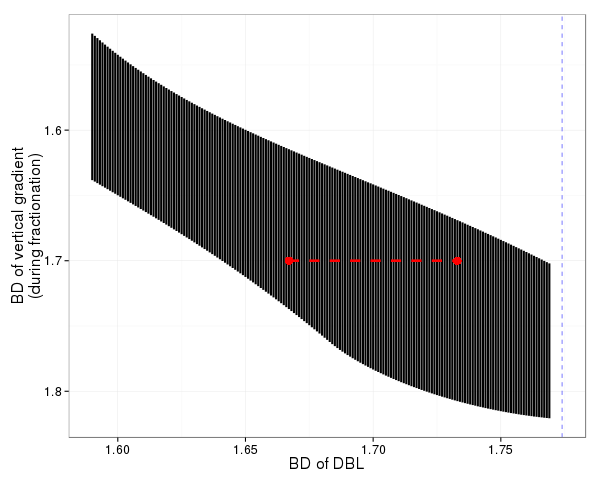

In [71]:
%%R -w 600
inFile = '/home/nick/notebook/SIPSim/t/genome100/DBL_index.txt'
df = read.delim(inFile, sep='\t') %>%
    gather(pos, vert_grad_BD, vert_gradient_BD_low, vert_gradient_BD_high)

# example
df.ex = data.frame('DBL_BD' = c(1.667, 1.733), 'vert_grad_BD' = c(1.7, 1.7))

# plot
ggplot(df, aes(DBL_BD, vert_grad_BD, color=pos, group=DBL_BD)) +
    #geom_point() +
    geom_line(color='black', size=1) +
    geom_point(data=df.ex, color='red', size=4) +
    geom_line(data=df.ex, aes(group=vert_grad_BD), color='red', linetype='dashed', size=1.2) +
    geom_vline(xintercept=1.774, linetype='dashed', alpha=0.5, color='blue') +  # theoretical max fragment BD
    scale_y_reverse() +
    labs(x='BD of DBL', y='BD of vertical gradient\n(during fractionation)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [68]:
%%R

w = 17545933.74
B = 1.14e9  
r_min = 2.6
r_max = 4.85

gradientRange = function(w, B, r_min, r_max){
    w / (2*B) * (r_max**2 - r_min**2)
}

gr = gradientRange(w, B, r_min, r_max)
print(c(1.6, 1.6 + gr))

[1] 1.600000 1.728997


In [63]:
%%R
#-- debug

# cfg run
w = 17545933.74
D = 1.71
B = 1.14e9  # CsCl at density of 1.70
I = 3.781204


BD2radius = function(x){ sqrt( ((x-D)*2*B/w) + I^2 ) }

BDs = seq(1.5, 1.7, 0.001)
sapply(BDs, BD2radius)

  [1]        NaN        NaN        NaN        NaN        NaN        NaN
  [7]        NaN        NaN        NaN        NaN        NaN        NaN
 [13]        NaN        NaN        NaN        NaN        NaN        NaN
 [19]        NaN        NaN        NaN        NaN        NaN        NaN
 [25]        NaN        NaN        NaN        NaN        NaN        NaN
 [31]        NaN        NaN        NaN        NaN        NaN        NaN
 [37]        NaN        NaN        NaN        NaN        NaN        NaN
 [43]        NaN        NaN        NaN        NaN        NaN        NaN
 [49]        NaN        NaN        NaN        NaN        NaN        NaN
 [55]        NaN        NaN        NaN        NaN        NaN        NaN
 [61]        NaN        NaN        NaN        NaN        NaN        NaN
 [67]        NaN        NaN        NaN        NaN        NaN        NaN
 [73]        NaN        NaN        NaN        NaN        NaN        NaN
 [79]        NaN        NaN        NaN        NaN        NaN    